<h1 align="center">US Retail Sales Time Series Modeling</h1> 
<h2 align="center">Amrit Sandhir</h2> 

### I: Background
### II: Exploratory Data Analysis
### III. Data Preprocessing 
### IV: Model Selection and Evaluation
### V: Conclusion

### I: Background

Many industries, businesses, and economists use time series data to model and forecast metrics of interest.  Levels of business revenue, customer attritions, traffic flows, energy spot prices, etc. have time dependent aspects, and exhibit trends, seasonal patterns, and correlations with previous values in time.  Models built to explain and forecast the series data must account for these processes and patterns to be considered accurate and of use.  Unlike cross-sectional linear models (point-in-time models) that assume independent, identically distributed (I.I.D) values with residuals N~(0,1), the same cannot be said of time series models.

This analysis will focus on the US retail sales time series, which is released by the Federal Reserve Economic Data (FRED) division on a monthly basis.  The monthly sales data for the prior month is released in the proceding month (e.g., data for US retail sales for March 2023 became available mid-April 2023).  Since US consumers account for two-thirds of US GDP, the retail sales data provides insights into the health of consumers, the economy, as well as changes in sales relative to prior months.  The non-seasonally adjusted US retail sales series can be found at https://fred.stlouisfed.org/series/RSXFSN and will be used in this analysis.

The analysis that follows will:

* conduct an Exploratory Data Analysis on the raw series,
* split the data into training sets and test sets, 
* transform the data to remove any trends and patterns as described above, 
* fit time series models to the training data and review their output,
* and compare model forecasts to the actual observed data on the test set series. 

We'll also introduce exogenous data, namely the monthly unemployment rate and a recession binary variable to indicate whether a recession was present in a given month or not (1 or 0). Models with exogenous data can provide useful information not captured directly in the series on its own. The non-seasonally adjusted unemployment rate data can be referenced at https://fred.stlouisfed.org/series/LNU04032235.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in US retail sales to dataframe
us_rtlsls_df=pd.read_csv(r'/Users/amritsandhir/Data/RSXFSN.csv', parse_dates=True, index_col='DATE')
us_rtlsls_df.index.freq='MS'
us_rtlsls_df.columns=['us_sales']
us_rtlsls_df.head()

,us_sales
DATE,
1992-01-01,130683
1992-02-01,131244
1992-03-01,142488
1992-04-01,147175
1992-05-01,152420


In [3]:
#read in unemployment rate data
unempl_rate=pd.read_csv(r'/Users/amritsandhir/Data/LNU04032235.csv', parse_dates=True, index_col='DATE')
unempl_rate.index.freq='MS'
unempl_rate.columns=['unemployment_rate']
print(unempl_rate.head())

#create a dataframe with recession indicator based on FED recession designation periods  
recessn_df=pd.DataFrame(data=0, columns=['recession_flag'], index=us_rtlsls_df.index)
recessn_df.loc['2001-03': '2001-11', 'recession_flag']=1
recessn_df.loc['2007-12': '2009-06', 'recession_flag']=1
recessn_df.loc['2020-02': '2020-04', 'recession_flag']=1
print(recessn_df.head())

            unemployment_rate
DATE                         
2000-01-01                5.0
2000-02-01                5.2
2000-03-01                5.1
2000-04-01                4.1
2000-05-01                4.3
            recession_flag
DATE                      
1992-01-01               0
1992-02-01               0
1992-03-01               0
1992-04-01               0
1992-05-01               0


### II: Exploratory Data Analysis

In [4]:
min_year=us_rtlsls_df.index.min().year
min_month=us_rtlsls_df.index.min().month

max_year=us_rtlsls_df.index.max().year
max_month=us_rtlsls_df.index.max().month

first_period=str(min_year)+'-'+str(min_month)
last_period=str(max_year)+'-'+str(max_month)

print('\nThe raw series begins in {} and ends on {}.\n'.format(first_period, last_period))


The raw series begins in 1992-1 and ends on 2023-3.



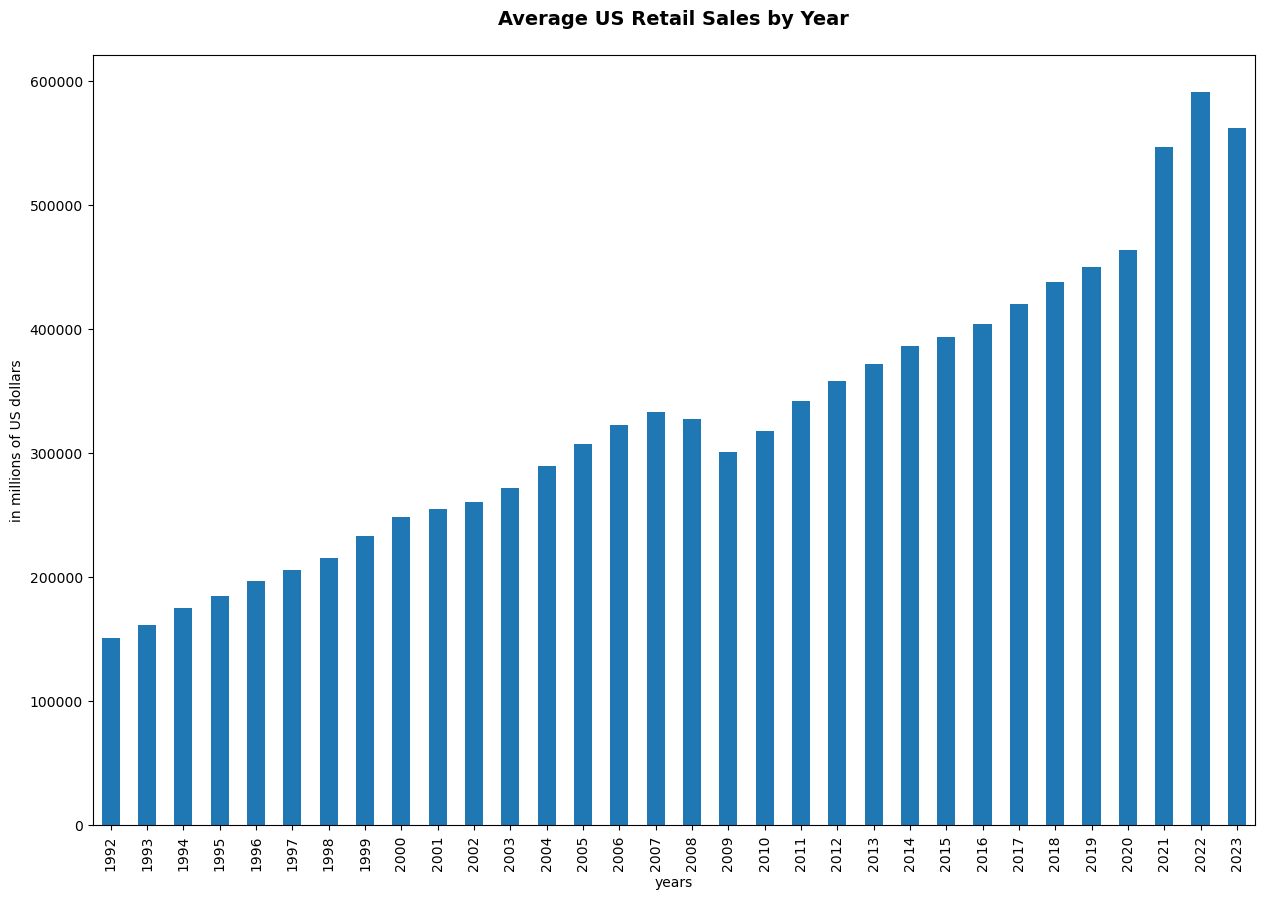

In [5]:
sales_by_year=us_rtlsls_df.groupby(us_rtlsls_df.index.year)['us_sales'].mean()
sales_by_year.plot(kind='bar', figsize=(15,10))
plt.title('Average US Retail Sales by Year\n', weight='bold', size=14)
plt.xlabel('years')
plt.ylabel('in millions of US dollars')
plt.show()

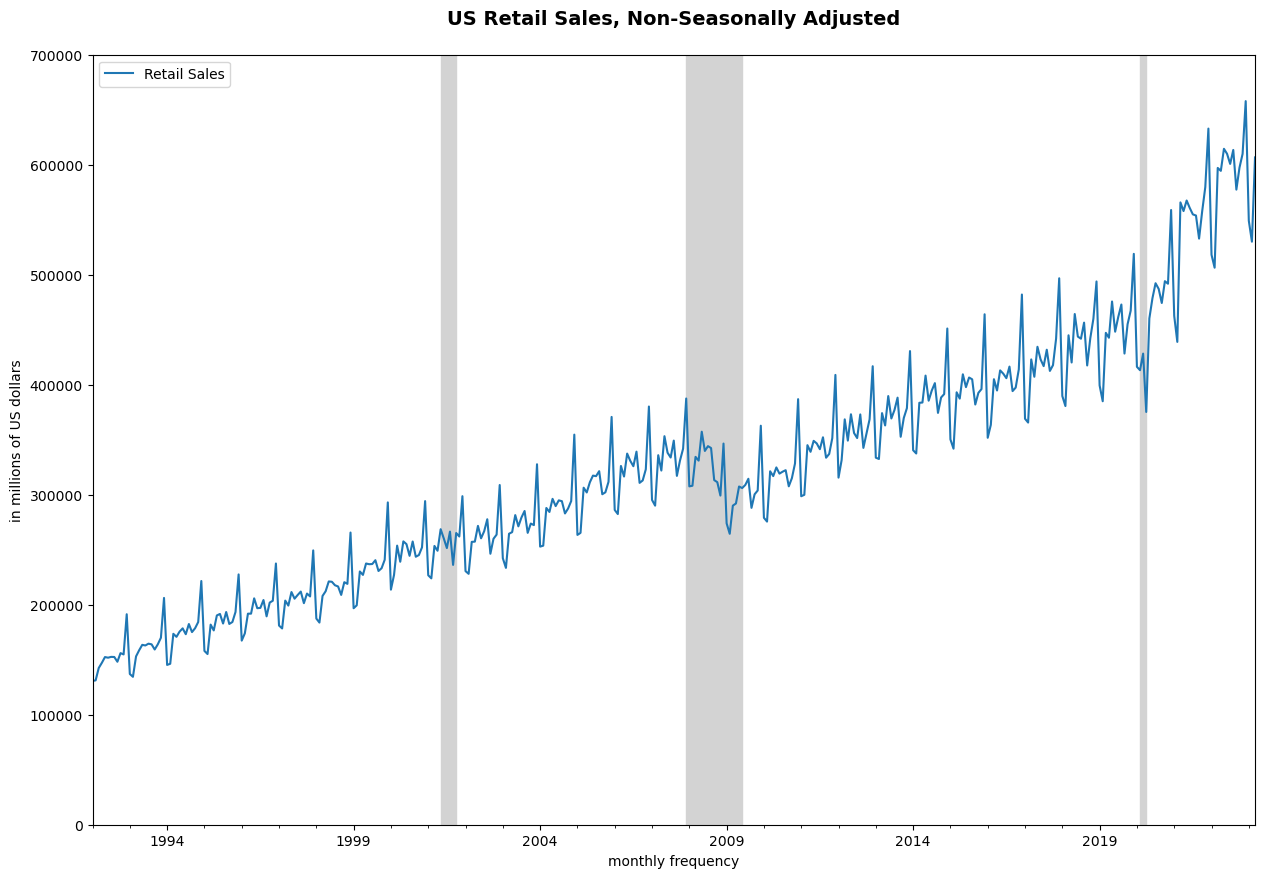

In [6]:
us_rtlsls_df.plot(figsize=(15,10), legend=False)
plt.legend(labels=['Retail Sales'], loc='upper left')
plt.fill_betweenx(y=[0,700000], x1='2001-05', x2='2001-10', color='lightgrey')
plt.fill_betweenx(y=[0,700000], x1='2007-12', x2='2009-06', color='lightgrey')
plt.fill_betweenx(y=[0,700000], x1='2020-02', x2='2020-04', color='lightgrey')
plt.ylabel('in millions of US dollars')
plt.xlabel('monthly frequency')
plt.title('US Retail Sales, Non-Seasonally Adjusted\n', weight='bold', size=14)
plt.ylim(0, 700000)
plt.show()

US retail sales exhibit an upward trend, as well as recurring patterns of peaks and troughs indicating seasonality.  The grey lines represent recessions, defined as two succesive declines in quarterly US GDP.  The recession that began in late 2007 and ended in mid-2009 clearly had an effect on sales. Recessions and business cycles can be thought of as cyclical components that tend to reoccur but with no obvious pattern in their recurrence rate. For example, a recession was recorded in 2001, then in 2007 (a difference of 6 years from the previous recession), and then a mild one in 2020 (a difference of 13 years).  This is important to note since the breadth and depth of recessions do impact US retail sales. 

Let's limit the time period for the series to get a better understanding and focus on the seasonal frequency.  

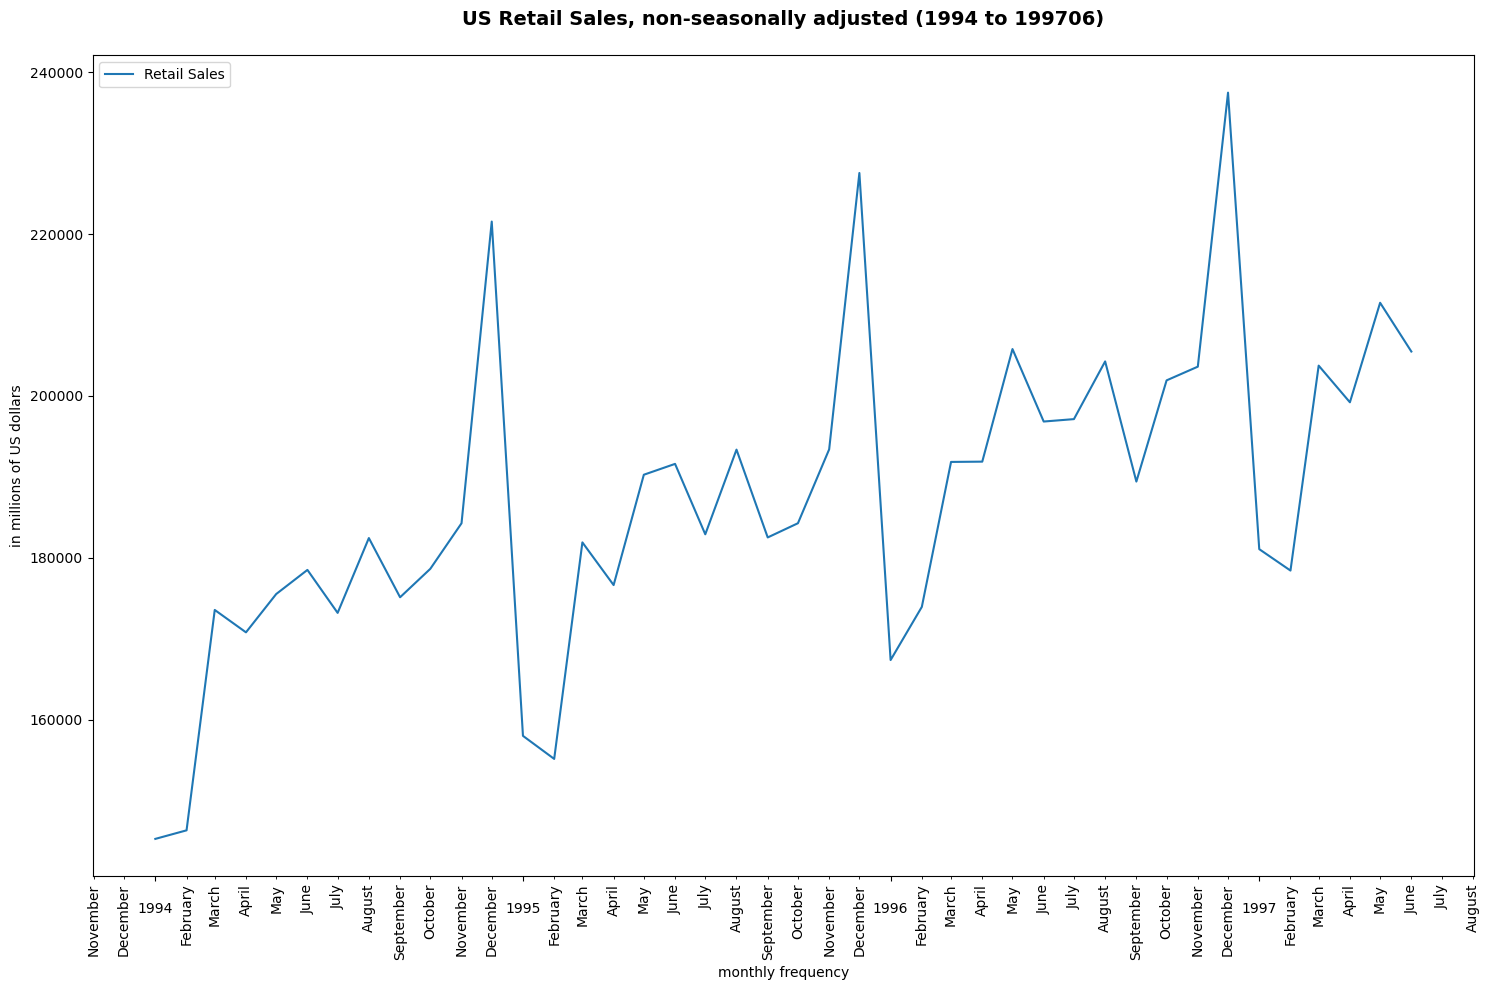

In [7]:
#limit graph from 1994 to mid-1997
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams["figure.autolayout"] = True

years = mdates.YearLocator()
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%B')
yearsFmt = mdates.DateFormatter('\n%Y')

dts = us_rtlsls_df['1994':'1997-06'].index.to_pydatetime()
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(dts, us_rtlsls_df['1994':'1997-06'])
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

plt.legend(labels=['Retail Sales'], loc='upper left')
plt.ylabel('in millions of US dollars')
plt.xlabel('monthly frequency')
plt.title('US Retail Sales, non-seasonally adjusted (1994 to 199706)\n', weight='bold', size=14)
plt.show()

The above chart provides a clear and intuitive indication of the seasonal pattern in US retail sales.  In effect, increases in sales are 'back-loaded' during the year and coincide with the Holidays.  The highest sales occur in the November/December months in any given year, and then drop off substantially in January of the following year.  We'll use the seasonal_decompose method to partition the above series into its trend, seasonality, and residuals components.

#### Split series and exogenous data into training and test sets

In [8]:
#split the US retail sales series into train set (2011-01 to 2020-12) and test set (2021-01 to 2023-03)
us_train, us_test=us_rtlsls_df['2011':'2020'], us_rtlsls_df['2021':]

#split the exogenous data series into train set (2011-01 to 2020-12) and test set (2021-01 to 2023-03)
exog_train=pd.concat([unempl_rate['2011-01': '2020'], recessn_df['2011-01': '2020']], axis=1)
exog_test=pd.concat([unempl_rate['2021-01': ], recessn_df['2021-01': ]], axis=1)

print('Length of series training data: {}'.format(len(us_train)))
print('Length of series test data: {}\n'.format(len(us_test)))

print('Length of exogenous training data: {}'.format(len(exog_train)))
print('Length of exogenous test data: {}'.format(len(exog_test)))

Length of series training data: 120
Length of series test data: 27

Length of exogenous training data: 120
Length of exogenous test data: 27


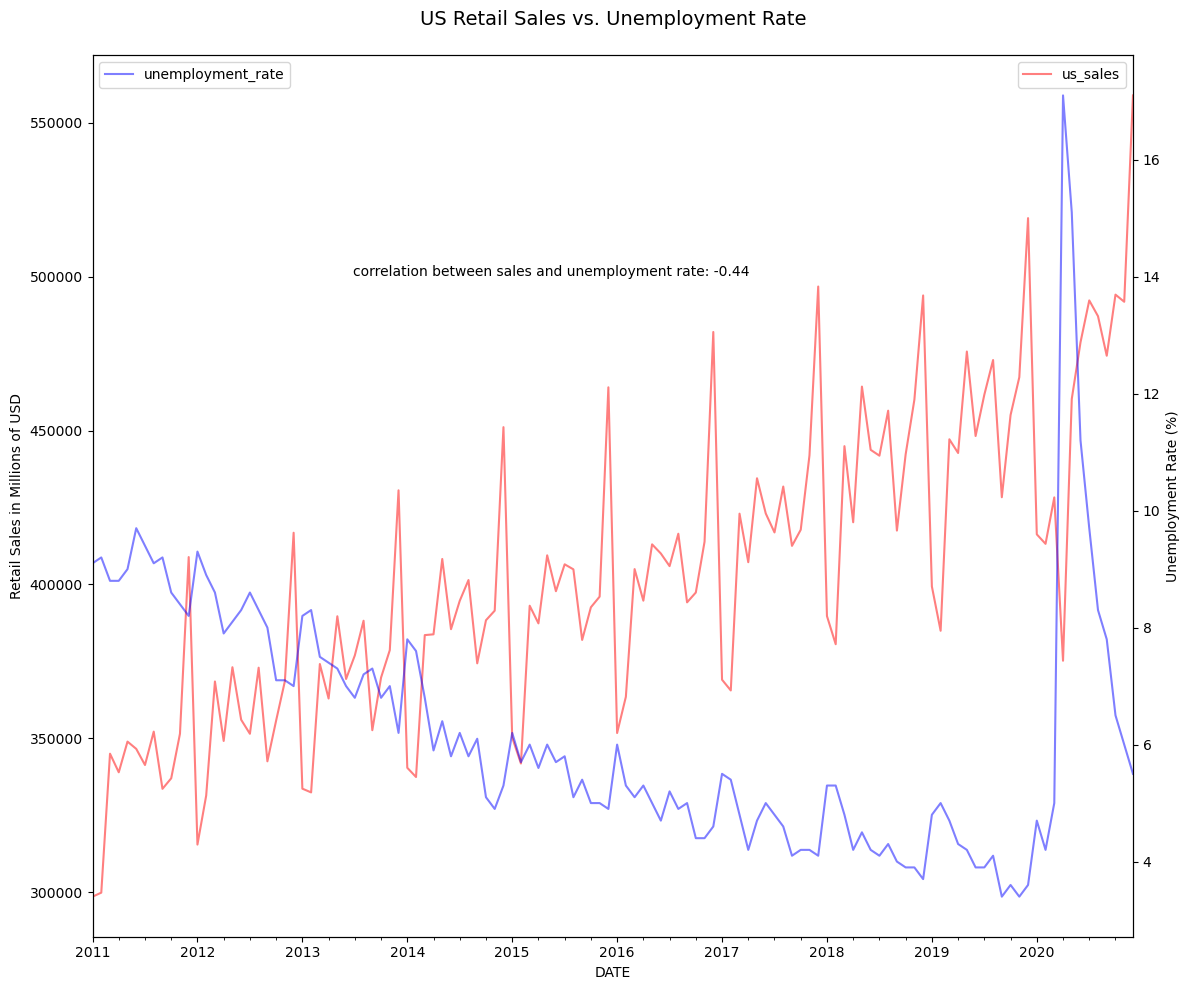

In [9]:
rho=np.corrcoef(us_train.us_sales, exog_train.unemployment_rate)

fig, ax=plt.subplots(figsize=(12,10))
ax2 = ax.twinx()
us_train.plot(color='red', ax=ax, alpha=0.5, label=False)
exog_train.unemployment_rate.plot(color='blue', ax=ax2, alpha=0.5)
ax.set_ylabel('Retail Sales in Millions of USD')
ax.set_label('US Retail Sales')
ax2.set_ylabel('Unemployment Rate (%)')
plt.legend(loc='upper left')
plt.text(x=0.25, y=0.75, transform=ax.transAxes, s='correlation between sales and unemployment rate: {}'.format(str(round(rho[0,1],2))))
plt.title('US Retail Sales vs. Unemployment Rate\n', size=14)
plt.show()

When we plot sales with the unemployment rate we find some degree of negative correlation between them.  The unemployment rate may be a good factor when we model the series.  

### III. Data Preprocessing 


In order to implement and use time series models, such as AR (auto regressive), MA (moving average), ARIMA (auto regressive integrated moving average), etc., the series must be made stationary.  A stationary series is one whose properties do not depend on the time at which the series is observed.  The observations should not contain any visible trend or seasonality, has constant variance (the distribution of residuals are centered around 0 and the distribution is constant along time), and the series' autocorrelation (relationship with previous values) is constant.

Along with visualization plots, the Augmented Dickey Fuller (adfuller) and the Kwiatkowski-Phillips-Schmidt-Shin (kpss) tests can be used to test for stationarity.  While the two tests address whether a series is stationarity they test from different angles.  The null hypothesis for the adfuller test is the series is assumed to be non-stationary, whereas the null hypothesis assumes the series is stationary under the kpss test.  

Therefore, a series is considered stationary if the p-value < 0.05 (type I error rate) under adfuller, and the p-value> 0.05 (type I error rate) under kpss.   We'll create a helper function to identify if a series is considered stationary under the adfuller and kpss criteria, and use it to identfy the approriate series that can be used for the time series model.  In general, the two tests agree but there can be instances when they depart in their conclusions.

Once the data has been transformed to a stationary series, we need to understand what lags, if any, are needed to model the AR and MA processes.  The plot_acf and plot_pacf functions allow us to visualize which lag periods are significant.  

We'll also fit the stationary series to different combinations of AR and MA orders and view their Akaike information criterion (AIC) and Bayesian information criterion (BIC) scores.  AIC and BIC are metrics that score how good models are given their parameters.  Models that produce better predictions are given lower scores and lower AR and MA model orders.  Both metrics prefer less complex models but the BIC penalizes model complexity more than AIC.  

Most times the models agree on the order terms but when they differ, the choice of which one to use depends on the use case.  If the goal is to produce a model for better predictions, AR/MA order terms with the lowest AIC score should be chosen.  If the use case is to identify a good explanatory model, the terms associated with the lowest BIC score should selected.  The goal of this analysis is to build a good forecast model and so we will use the AIC.

#### Testing for Stationarity 

In [10]:
#helper function to test for stationarity
def stationary_tests(srs):
    
    kpss_tstat, kpss_pval=kpss(srs)[0], kpss(srs)[1]
    
    print('test statistic: {:0.5f} p-value: {:0.4f} under kpss'.format(kpss_tstat, kpss_pval))
    
    if kpss_pval<0.05:
        print('Series is considered non-stationary under kpss\n')
    else:
        print('Series is considered stationary under kpss\n')

        
    adf_tstat, adf_pval=adfuller(srs)[0], adfuller(srs)[1]
    
    print('test statistic: {:0.5f} p-value: {:0.4f} under adfuller'.format(adf_tstat, adf_pval))

    if adf_pval>0.05:
        print('Series is considered non-stationary under adfuller\n')
    else:
        print('Series is considered stationary under adfuller\n')
    

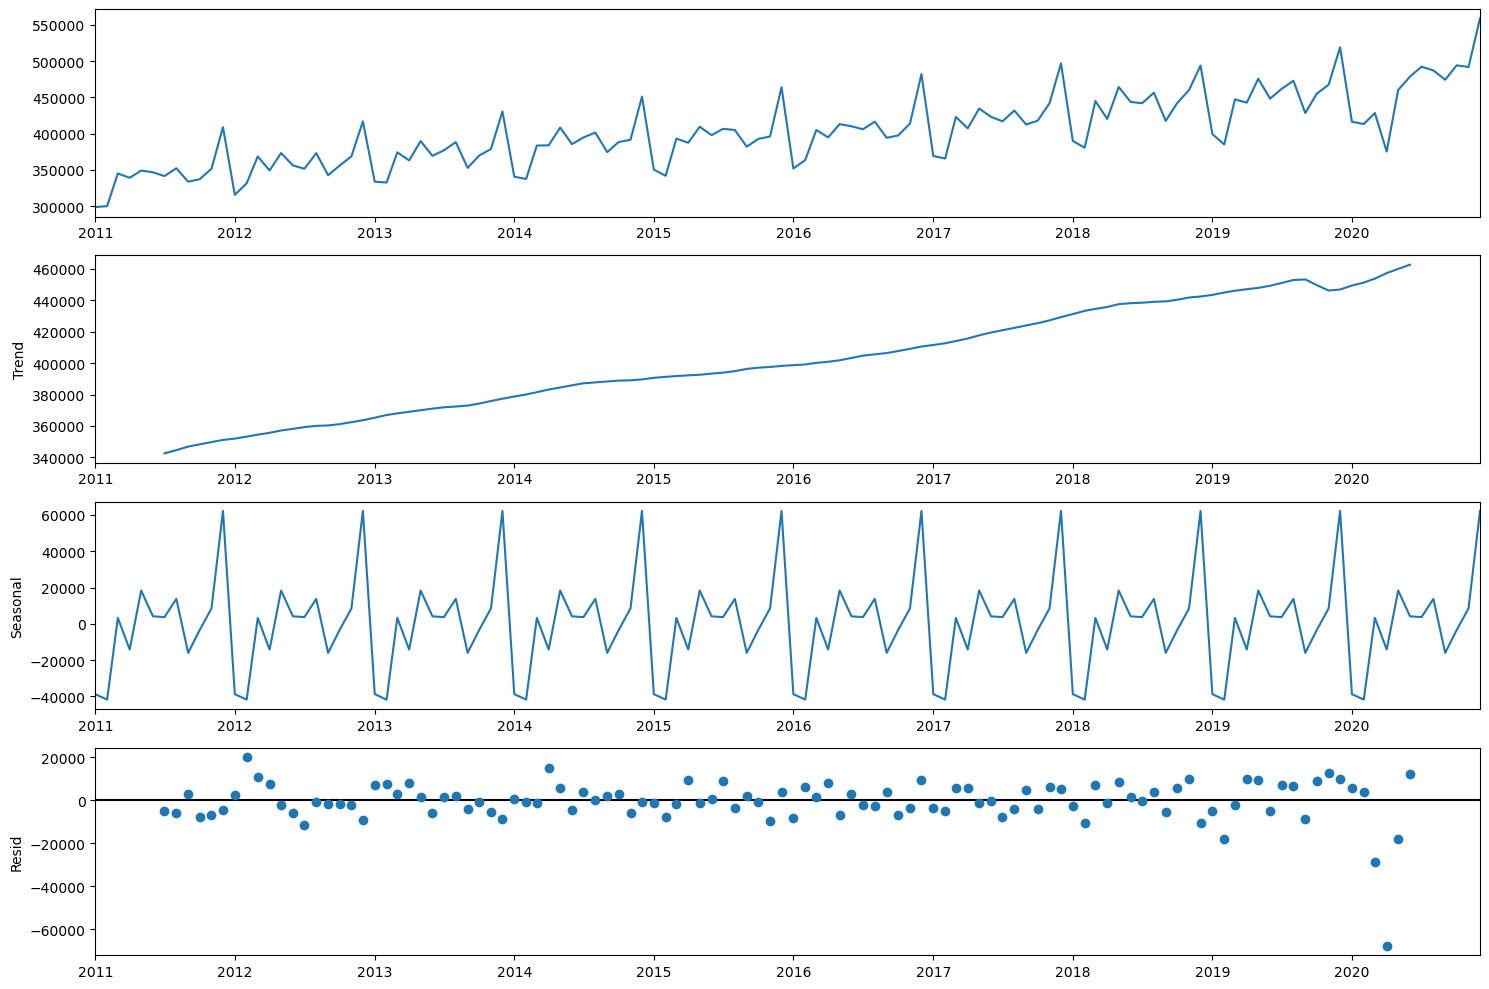

test statistic: 2.02960 p-value: 0.0100 under kpss
Series is considered non-stationary under kpss

test statistic: -0.09449 p-value: 0.9500 under adfuller
Series is considered non-stationary under adfuller



In [11]:
seasonal_decompose(us_train, period=12).plot()
plt.show()

stationary_tests(us_train)

The adfuller and kpss both indicate the series is non-stationary.  From the seasonal decomposition plots, we can see overall trend is close to linear and the 'Seasonal' plot shows the periodic 12 month patterns already understood.  The 'Resid' plot indicates the residuals being randomly distributed around 0, but beginning in 2020 we see the residual distribution widens.  This is indicative of non-constant variance which must be corrected for the model to be properly calibrated.  

There are a few options to make a time series stationary.

--taking the difference

--take the log change between sucessive periods
    
--take the square root

We will implement a combination the first and third option.  Specifically, we take the square root of the absolute value of first-order differences.  We'll decompose the transformed series and run the stationary_tests helper function to generate the adfuller and kpss p-values to determine whether the data is stationary, and if the transformed series can be used in a model. 

#### Tranformations for Stationarity 

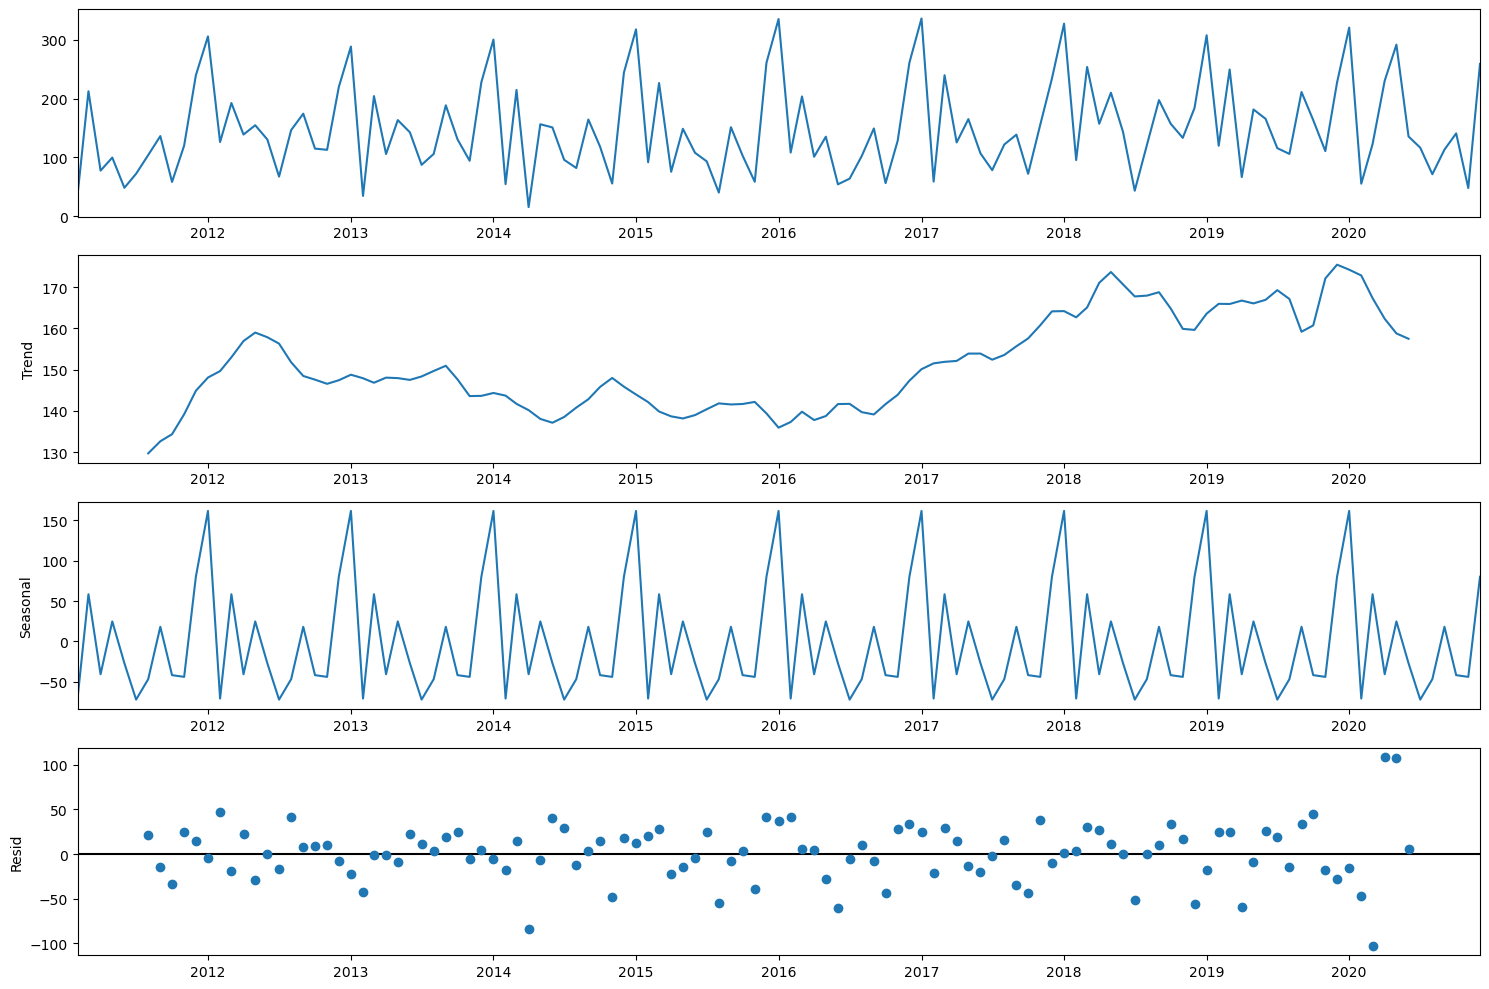

test statistic: 0.22156 p-value: 0.1000 under kpss
Series is considered stationary under kpss

test statistic: -1.98359 p-value: 0.2938 under adfuller
Series is considered non-stationary under adfuller



In [12]:
#take the square root of the absolute first-order differences
us_train_1st_diff_df=np.sqrt(np.abs(us_train.diff())).dropna()

seasonal_decompose(us_train_1st_diff_df, period=12).plot()
plt.show()

stationary_tests(us_train_1st_diff_df)

The two tests seem to disagree. The adfuller p-value 0.2938 is above the 0.05 and fails to reject the null hypothesis that the series non-stationary.  In contrast, the kpss p-value of 0.1>0.05 and considers the series stationary.  

Let's consider another transformation by taking the log of the series and then difference the data.

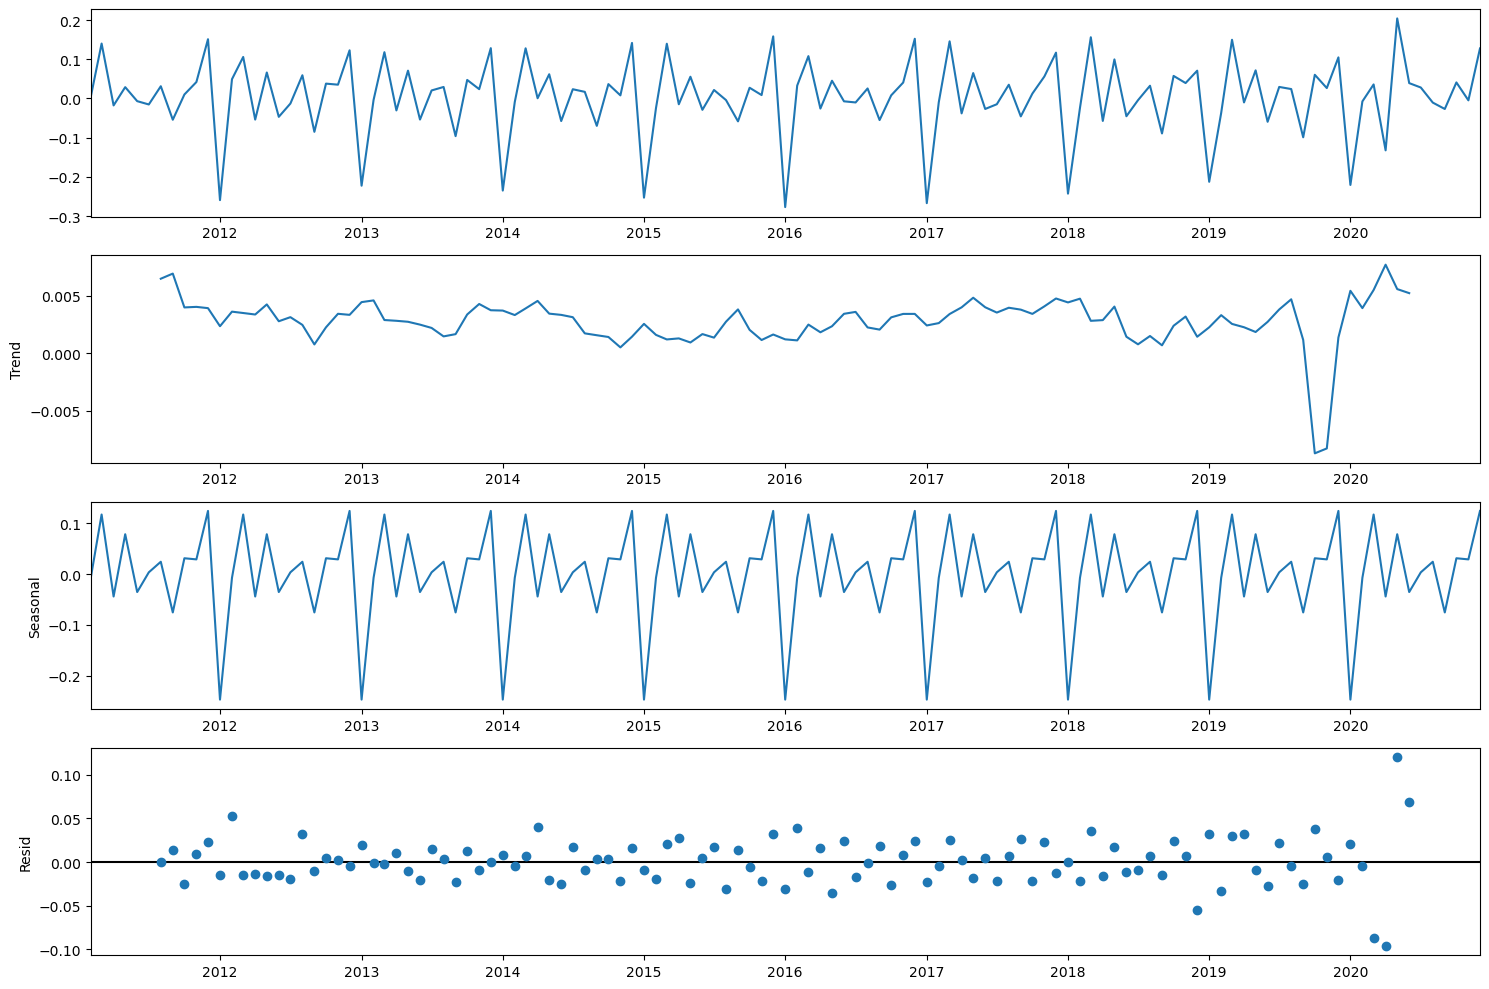

test statistic: 0.15863 p-value: 0.1000 under kpss
Series is considered stationary under kpss

test statistic: -6.83200 p-value: 0.0000 under adfuller
Series is considered stationary under adfuller



In [13]:
#log of first-order differences
us_train_log_change_df=np.log(us_train).diff().dropna()

seasonal_decompose(us_train_log_change_df, period=12).plot()
plt.show()

stationary_tests(us_train_log_change_df)

The adfuller and kpss tests now both agree the first order differenced log series to be stationary.  We can see from the 1st plot above, there is no obvious pattern outside of the seasonal fluctuations apparent in the 3rd (Seasonal) plot.  The 2nd (Trend) plot above shows no trend, and the residuals in the last plot show no obvious patterns and appear to be white noise.

The next step is to identify the AR and MA orders.  We will generate plots from the autocorrelation (AC) and partial autocorrelation (PAC) functions to visualize the degree of dependence and whether the data follows an AR(p), MA(q) or ARIMA(p,1,q) process.  The AC and PAC plots can help identity the number of lags to use for the MA(q) and AR(p) order terms.  These plots do not always make clear what lag orders are needed.  As a complement, we'll generate several models based on different p and q orders, and see which produce the lowest AIC and BIC scores. 

#### Identifying AR and MA order terms 

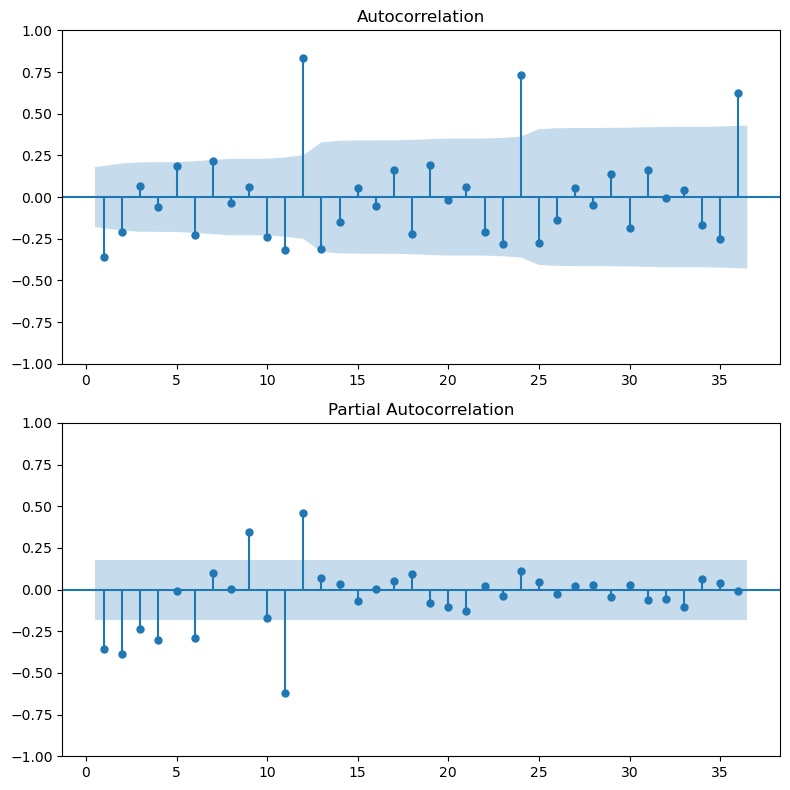

In [14]:
fig, (ax1, ax2)=plt.subplots(2,1, figsize=(8,8))

plot_acf(us_train_log_change_df, lags=36, zero=False, ax=ax1)
plot_pacf(us_train_log_change_df, lags=36, zero=False, method='ywm', ax=ax2)

plt.show()

#### AIC and BIC scores WITHOUT exogenous data in model fit

In [15]:
aic_bic_orders=[]

#loop over AR order
for p in range(0,5):
    
    #loop over MA order
    for q in range(0,5):
        
        #fit model
        mdl=SARIMAX(np.log(us_train), order=(p,1,q))
        
        rslts=mdl.fit(disp=False)
        
        #add p,q, AIC, and BIC to list
        aic_bic_orders.append((p,q,rslts.aic, rslts.bic))

order_df=pd.DataFrame(data=aic_bic_orders, columns=['p', 'q', 'AIC', 'BIC'])

In [16]:
#order terms with lowest AIC score
print(order_df.sort_values(by='AIC', ascending=True).head(), '\n')

#order terms with lowest BIC score
print(order_df.sort_values(by='BIC', ascending=True).head())

    p  q         AIC         BIC
23  4  3 -294.682932 -272.449944
24  4  4 -292.876585 -267.864474
3   0  3 -271.757464 -260.640970
13  2  3 -271.568572 -254.893831
22  4  2 -271.447856 -251.993991 

    p  q         AIC         BIC
23  4  3 -294.682932 -272.449944
24  4  4 -292.876585 -267.864474
1   0  1 -267.881379 -262.323132
3   0  3 -271.757464 -260.640970
7   1  2 -270.226302 -259.109808


In [17]:
#ARIMA(4,1,3)

mdl=SARIMAX(endog=np.log(us_train), order=(4,1,3))

results=mdl.fit(disp=False)

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               us_sales   No. Observations:                  120
Model:               SARIMAX(4, 1, 3)   Log Likelihood                 155.341
Date:                Mon, 24 Apr 2023   AIC                           -294.683
Time:                        15:40:50   BIC                           -272.450
Sample:                    01-01-2011   HQIC                          -285.655
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5280      0.141    -10.802      0.000      -1.805      -1.251
ar.L2         -0.9680      0.279     -3.473      0.001      -1.514      -0.422
ar.L3         -0.3895      0.266     -1.465      0.1

The model produces Prob(Q) of 0.40>0.05 but the Prob(JB) of 0.02<0.05. The residuals are uncorrelated with their previous values but are not considered normally distributed accroding to the Prob(JB) p-value.  Let's view the residual diagnostics and distribution.

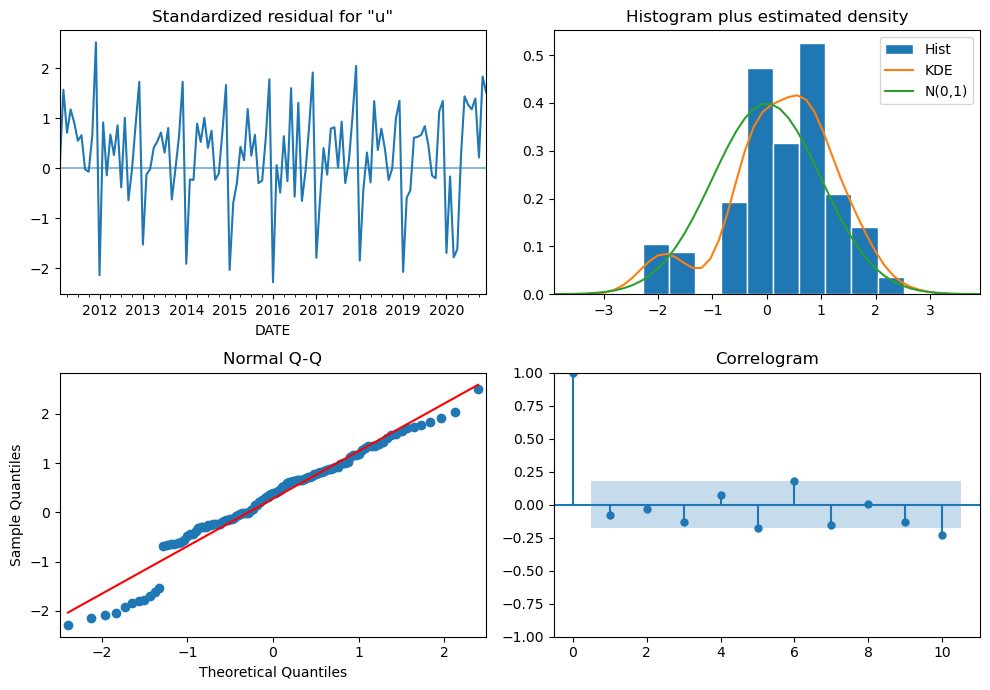

In [18]:
results.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

#### AIC and BIC scores WITH exogenous data in model fit

In [19]:
aic_bic_orders=[]

#loop over AR order
for p in range(0,5):
    
    #loop over MA order
    for q in range(0,5):
        
        #fit model with exogenous data
        mdl=SARIMAX(np.log(us_train), exog=exog_train, order=(p,1,q))
        
        rslts=mdl.fit(disp=False)
        
        #add p,q, AIC, and BIC to list
        aic_bic_orders.append((p,q,rslts.aic, rslts.bic))

order_df=pd.DataFrame(data=aic_bic_orders, columns=['p', 'q', 'AIC', 'BIC'])

In [20]:
#order terms with lowest AIC score with exogenous data in model fit
print(order_df.sort_values(by='AIC', ascending=True).head(), '\n')

#order terms with lowest BIC score with exogenous data in model fit
print(order_df.sort_values(by='BIC', ascending=True).head())

    p  q         AIC         BIC
4   0  4 -298.681819 -279.227954
3   0  3 -295.059083 -278.384342
13  2  3 -291.544550 -269.311562
8   1  3 -291.435194 -271.981330
24  4  4 -291.276803 -260.706445 

    p  q         AIC         BIC
4   0  4 -298.681819 -279.227954
3   0  3 -295.059083 -278.384342
1   0  1 -283.279039 -272.162545
8   1  3 -291.435194 -271.981330
11  2  1 -287.598616 -270.923875


In [21]:
#ARIMA(0,1,4) with exogenous data

mdl=SARIMAX(endog=np.log(us_train), exog=exog_train, order=(0,1,4))

results=mdl.fit(disp=False)

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               us_sales   No. Observations:                  120
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 156.341
Date:                Mon, 24 Apr 2023   AIC                           -298.682
Time:                        15:40:54   BIC                           -279.228
Sample:                    01-01-2011   HQIC                          -290.782
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
unemployment_rate    -0.0082      0.003     -3.129      0.002      -0.013      -0.003
recession_flag       -0.1252      0.032     -3.868      0.000      -0.189      -0.062
ma.L1                -1.

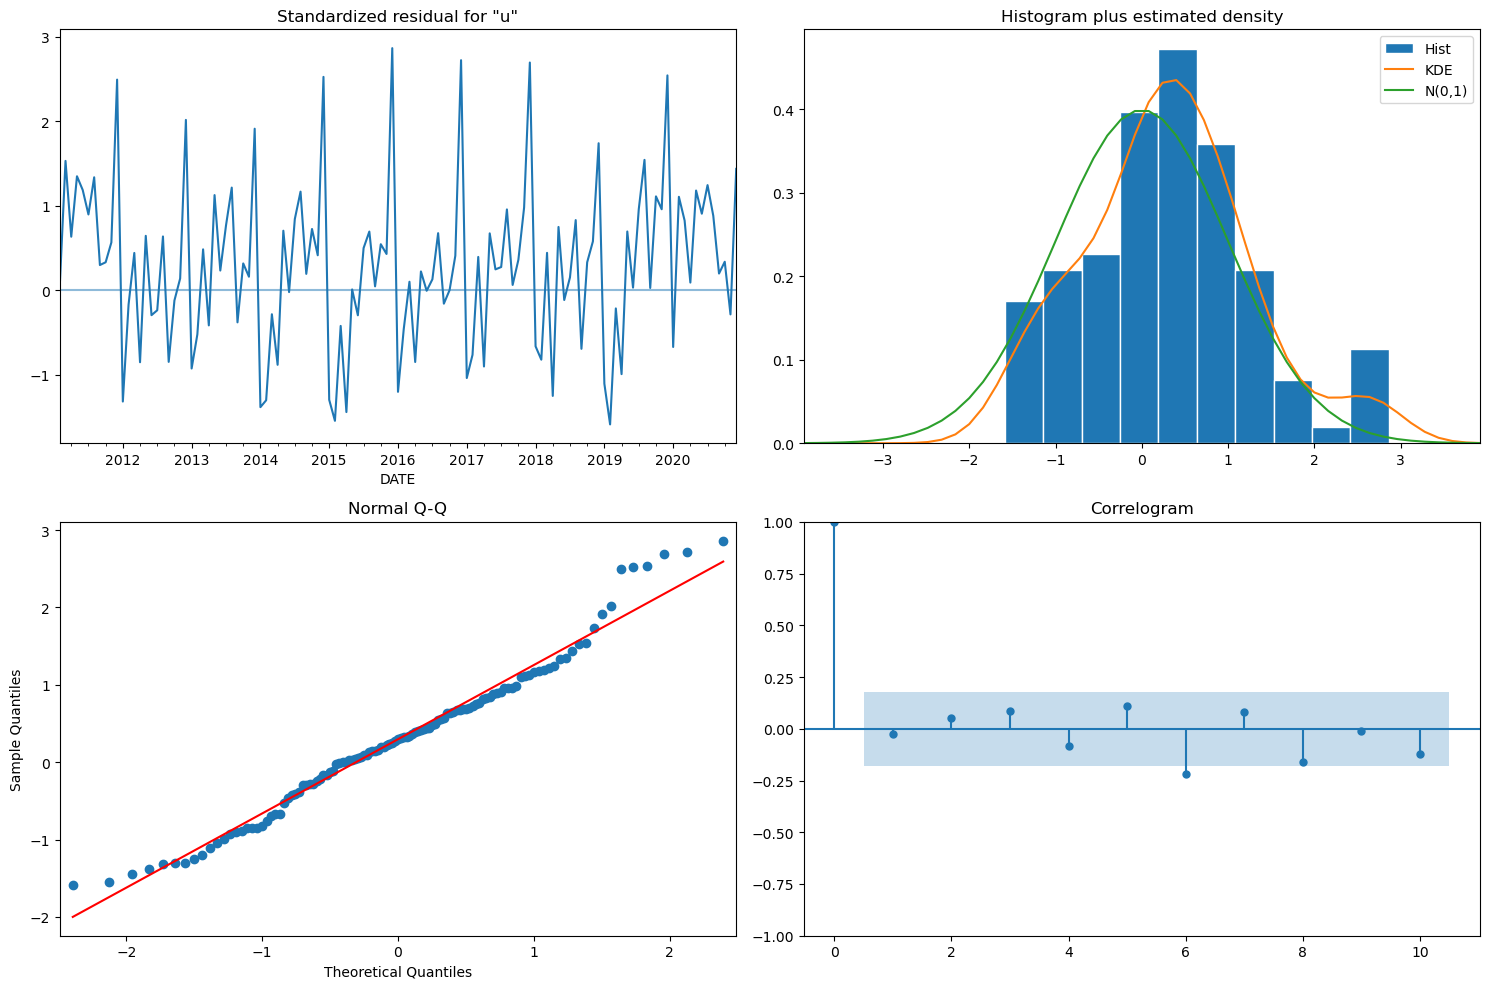

In [22]:
results.plot_diagnostics()
plt.show()

The model with exogenous variables produces Prob(Q) of 0.80>0.05 and Prob(JB) of 0.26>0.05.  We are confident the residuals are uncorrelated and are normally distributed, respectively.  

So far, we've fit two models on the training data.  One included the log series with a 1st-order difference (log(y_t) - log(y_t-1), whereas the second model included exogenous data.   The former produced an arima model with (p,d,q) of (4,1,3) and the latter produced a (0,1,4) orders.

We've seen US retail sales have a recurring 12 month pattern of seasonality but have not accounted for it yet.  We've also not forecast and validated our fiited models on the test periods (2021-01 to 2023-03) and compared them to the actual data for that time period.  

We'll do so next by fitting four models on the training data, and comparing their forecasts on the test period with the actual observations.  We'll evaluate the models based on their mean absolute error (MAE) and mean absolute percentage error (MAPE).  The MAE returns the mean of absolute differences between actual and forecast values, while MAPE returns the mean of the absolute percentage differences between actual and forecast data.  

In order to streamline this analysis we'll create a function that automates the model fitting and evaluation processes.

### IV: Model Selection and Evaluation

#### model selection and evaluation function

In [23]:
def sarimax_eval_func(srs, model_label, exog=None, order=None, seasonality=None):
    
    mdl=SARIMAX(endog=srs, exog=exog, order=order, seasonal_order=seasonality)

    results=mdl.fit(disp=False)

    print(results.summary())
    
    results.plot_diagnostics(figsize=(10,7))
    plt.tight_layout()
    plt.show()
    
    forecast=results.get_forecast(27, exog=exog_test)

    #inverse transform forecasts and CI's from log to exp 
    mean_forecast=np.exp(forecast.predicted_mean)
    confidence_intervals=np.exp(forecast.conf_int())
    
    mae=mean_absolute_error(us_test.values, mean_forecast)
    mape=mean_absolute_percentage_error(us_test.values, mean_forecast)
    
    fig, ax=plt.subplots(figsize=(10,10))
    plt.plot(us_test.index, us_test.values, color='blue', alpha=0.5, label='actual US retail sales')

    plt.plot(mean_forecast.index, mean_forecast, color='orange', label='forecast US retail sales')

    plt.fill_between(confidence_intervals.index, 
                     confidence_intervals['lower us_sales'], 
                     confidence_intervals['upper us_sales'], 
                     color='lightgrey', alpha=0.25)
    plt.legend(loc='upper left')
    plt.text(x=0.05, y=0.85,transform=ax.transAxes, s='mean absolute error: ${}'.format((round(mae,1))))
    plt.text(x=0.05, y=0.82,transform=ax.transAxes, s='mean absolute percentage error: {}%'.format((round(mape*100,2))))
    plt.title('Actual vs. Forecasted US Retail Sales on Test Set', weight='bold', size=14)
    plt.ylabel('In millions of US dollars')

    plt.show()
    
    if seasonality==None:
        return {'model_label': [model_label],
                'AIC': [results.aic],
                'MAPE': [round(mape*100,3)],
                 'MAE': [mae],
                
                 'p_order': [order[0]],
                 'd_order': [order[1]],
                 'q_order': [order[2]],
            
                 'P_seasonal_order': [None],
                 'D_seasonal_order': [None],
                 'Q_seasonal_order': [None],
                 'S_seasonal_order': [None]}, results
    else:
            
        return {'model_label': [model_label],
                'AIC': [results.aic],
                'MAPE': [round(mape*100,3)],
                 'MAE': [mae],
                
                'p_order': [order[0]],
                'd_order': [order[1]],
                'q_order': [order[2]],
            
            
                'P_seasonal_order': [seasonality[0]],
                'D_seasonal_order': [seasonality[1]],
                'Q_seasonal_order': [seasonality[2]],
                'S_seasonal_order': [seasonality[3]]}, results

#### Model 0: log difference model (p,d,q)=(4,1,3)

                               SARIMAX Results                                
Dep. Variable:               us_sales   No. Observations:                  120
Model:               SARIMAX(4, 1, 3)   Log Likelihood                 155.341
Date:                Mon, 24 Apr 2023   AIC                           -294.683
Time:                        15:40:55   BIC                           -272.450
Sample:                    01-01-2011   HQIC                          -285.655
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5280      0.141    -10.802      0.000      -1.805      -1.251
ar.L2         -0.9680      0.279     -3.473      0.001      -1.514      -0.422
ar.L3         -0.3895      0.266     -1.465      0.1

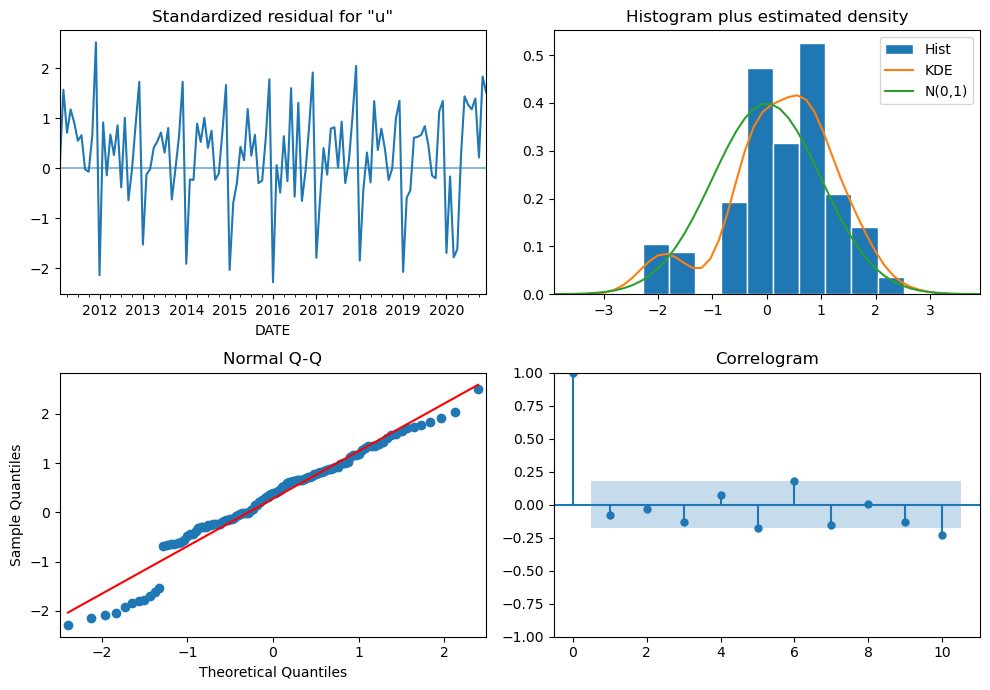

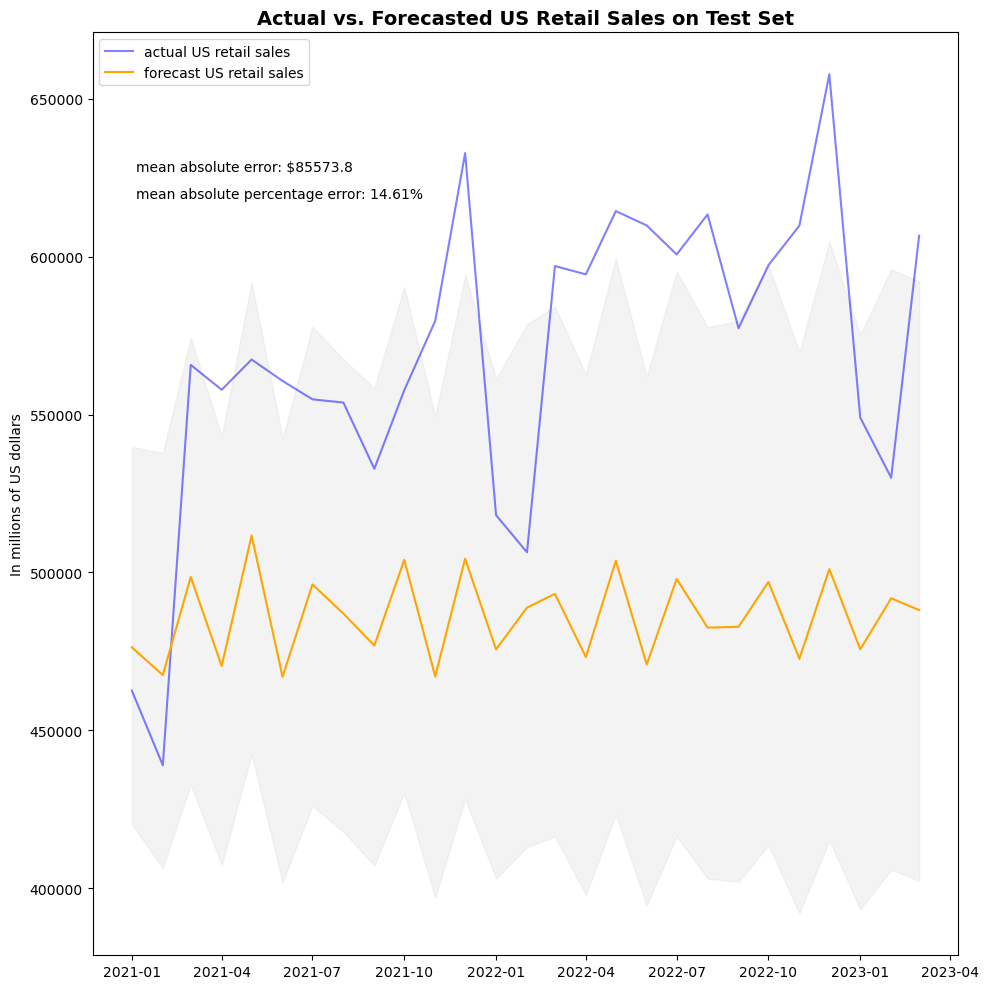

In [24]:
log_diff_dict,log_diff_mdl=sarimax_eval_func(srs=np.log(us_train), 
                                                model_label='log_differenced', 
                                                order=(4,1,3))

#### Model 1: log difference incorporating seasonality model (p,d,q) (P,D,Q,S) =(4,1,3) (1,0,0,12)

                                      SARIMAX Results                                      
Dep. Variable:                            us_sales   No. Observations:                  120
Model:             SARIMAX(4, 1, 3)x(1, 1, [], 12)   Log Likelihood                 232.174
Date:                             Mon, 24 Apr 2023   AIC                           -446.349
Time:                                     15:40:56   BIC                           -422.293
Sample:                                 01-01-2011   HQIC                          -436.597
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7602      0.863     -0.881      0.378      -2.452       0.931
ar.L2         -0.2689      

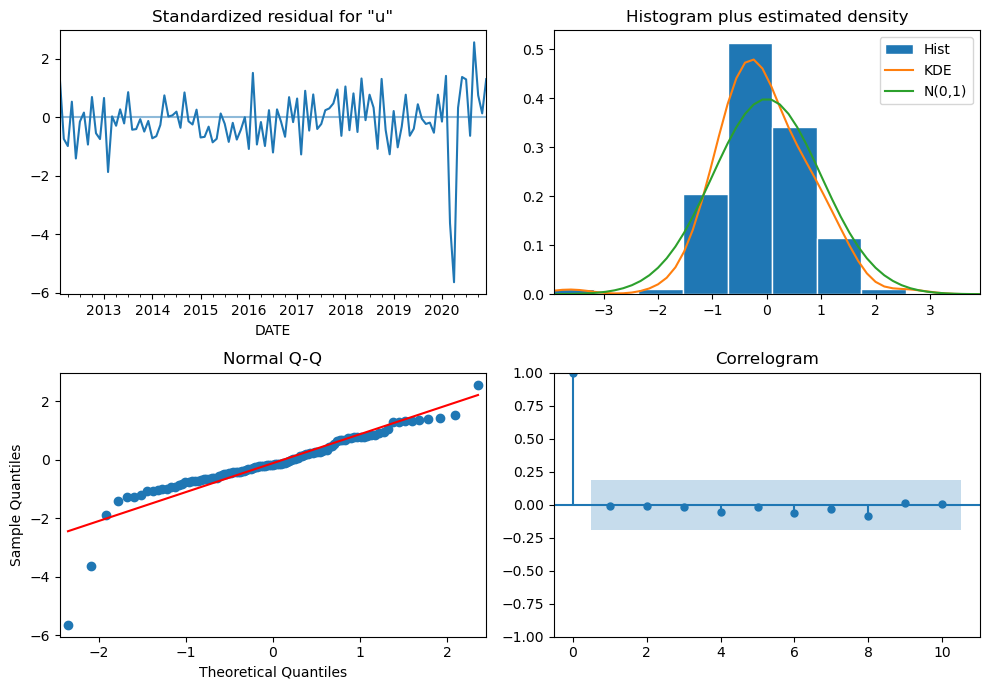

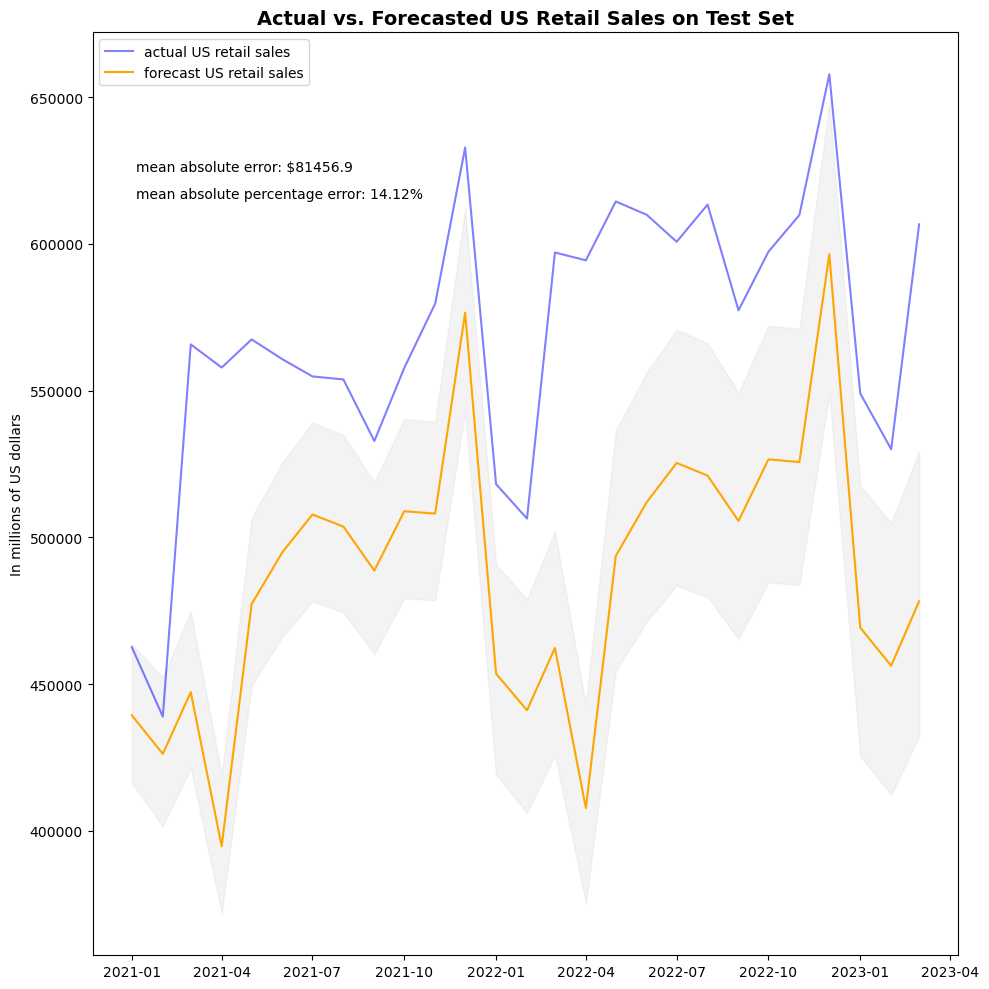

In [25]:
log_diff_seasn_dict, log_diff_seasn_mdl=sarimax_eval_func(srs=np.log(us_train), 
                                                            model_label='log_differenced_with_seasonality', 
                                                            order=(4,1,3),
                                                            seasonality=(1,1,0,12))

#### Model 2: log difference incorporating exogenous data model (p,d,q)=(0,1,4)

                               SARIMAX Results                                
Dep. Variable:               us_sales   No. Observations:                  120
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 156.341
Date:                Mon, 24 Apr 2023   AIC                           -298.682
Time:                        15:40:57   BIC                           -279.228
Sample:                    01-01-2011   HQIC                          -290.782
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
unemployment_rate    -0.0082      0.003     -3.129      0.002      -0.013      -0.003
recession_flag       -0.1252      0.032     -3.868      0.000      -0.189      -0.062
ma.L1                -1.

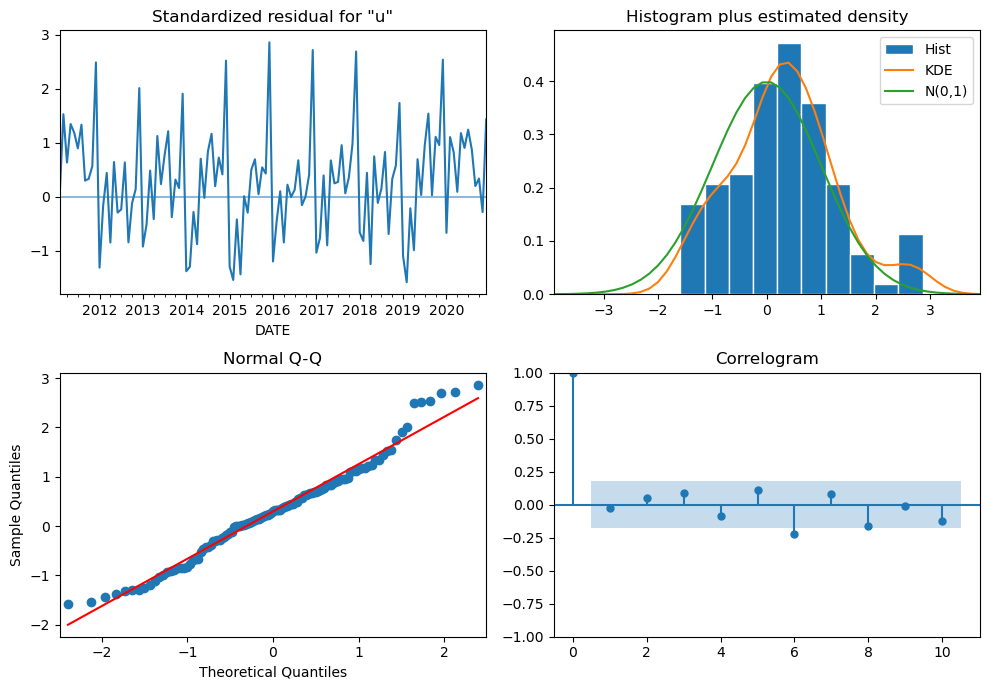

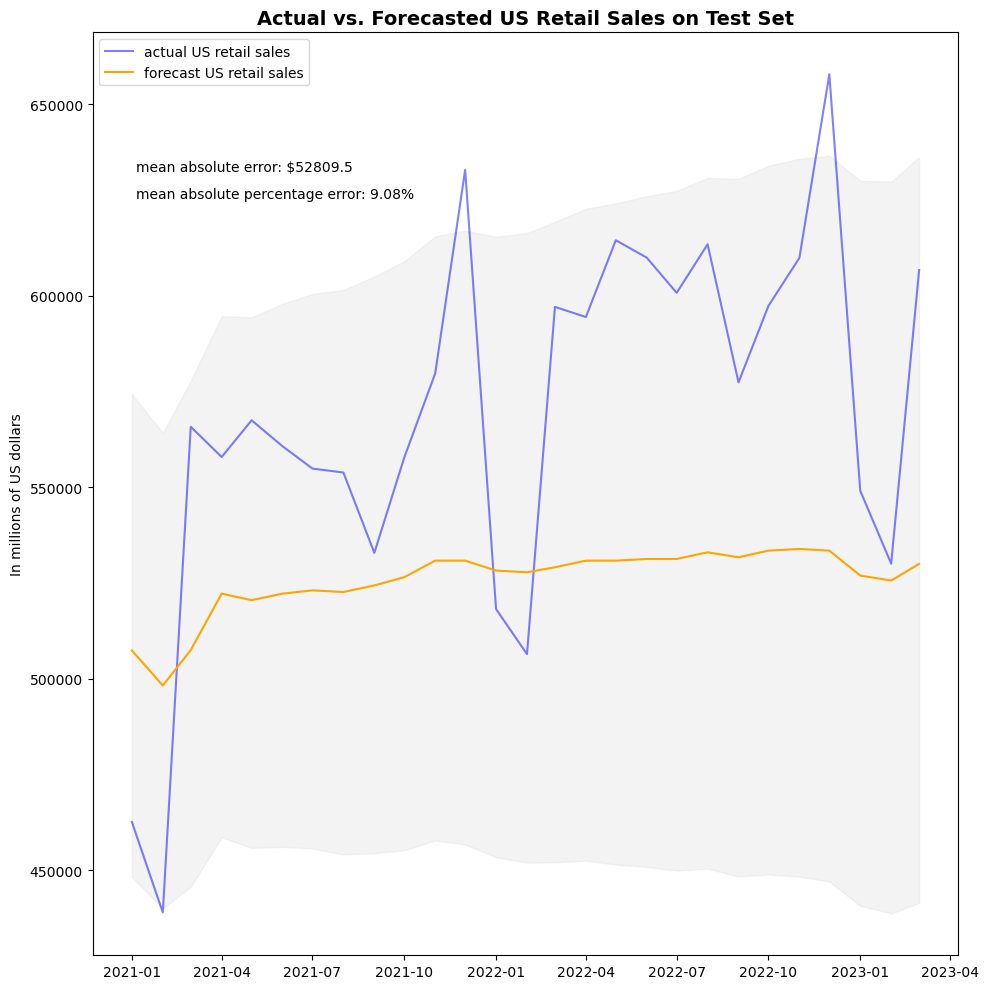

In [26]:
log_diff_exog_dict, log_diff_exog_mdl=sarimax_eval_func(srs=np.log(us_train), 
                                                          model_label='log_differenced_with_exog', 
                                                          exog=exog_train, order=(0,1,4))

#### Model 3: log difference incorporating seasonality and exogenous data model (p,d,q) (P,D,Q,S)=(0,1,4) (1,0,0,12)

                                      SARIMAX Results                                      
Dep. Variable:                            us_sales   No. Observations:                  120
Model:             SARIMAX(0, 1, 4)x(1, 1, [], 12)   Log Likelihood                 251.940
Date:                             Mon, 24 Apr 2023   AIC                           -487.880
Time:                                     15:40:59   BIC                           -466.497
Sample:                                 01-01-2011   HQIC                          -479.212
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
unemployment_rate    -0.0102      0.002     -5.249      0.000      -0.014      -0.006
recess

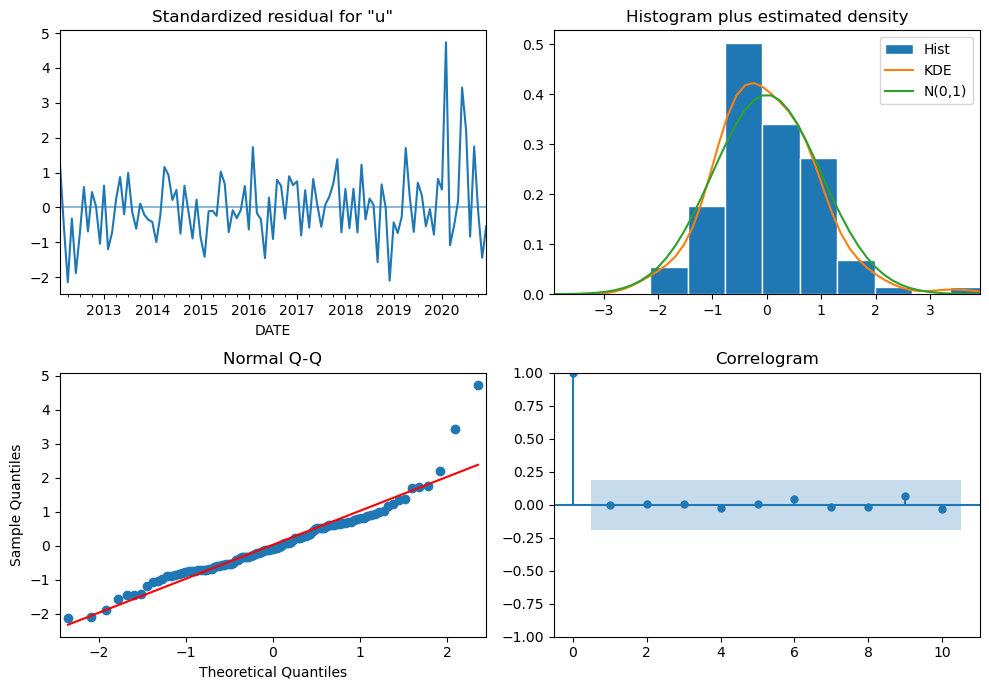

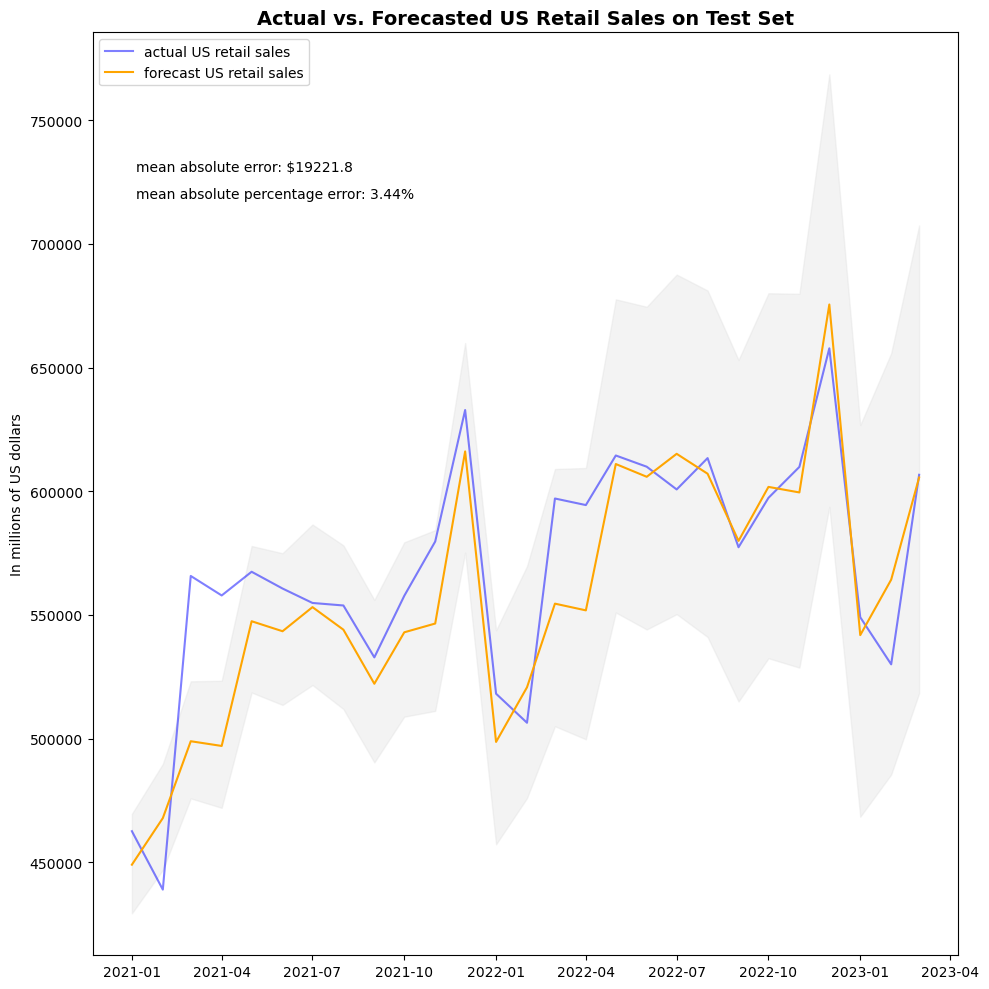

In [27]:
log_diff_exog_seasn_dict, log_diff_exog_seasn_mdl=sarimax_eval_func(srs=np.log(us_train), 
                                                    model_label='log_differenced_with_exog_and_seasonality', 
                                                    exog=exog_train, order=(0,1,4), 
                                                                      seasonality=(1,1,0,12))

In [28]:
df=pd.DataFrame()
df=pd.DataFrame(data=log_diff_dict)
df=pd.concat([df, pd.DataFrame(data=log_diff_seasn_dict)], axis=0)
df=pd.concat([df, pd.DataFrame(data=log_diff_exog_dict)], axis=0)
df=pd.concat([df, pd.DataFrame(data=log_diff_exog_seasn_dict)], axis=0)
df=df.reset_index(drop=True)

In [29]:
df.sort_values(by='MAPE')

,model_label,AIC,MAPE,MAE,p_order,d_order,q_order,P_seasonal_order,D_seasonal_order,Q_seasonal_order,S_seasonal_order
3,log_differenced_with_exog_and_seasonality,-487.880037,3.444,19221.802560,0,1,4,1,1,0,12
2,log_differenced_with_exog,-298.681819,9.078,52809.487650,0,1,4,None,None,None,None
1,log_differenced_with_seasonality,-446.348548,14.119,81456.927670,4,1,3,1,1,0,12
0,log_differenced,-294.682932,14.609,85573.833447,4,1,3,None,None,None,None


Based on the lowest AIC score of -487 and lowest MAPE of 3.44%, the best model is the one that incorporates both seasonality and exogenous data.  The model's coefficients are shown below.  

In [30]:
rslts=log_diff_exog_seasn_mdl.summary()
rslts.tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
unemployment_rate,-0.0102,0.002,-5.249,0.000,-0.014,-0.006
recession_flag,-0.0767,0.008,-9.340,0.000,-0.093,-0.061
ma.L1,-0.7823,0.108,-7.257,0.000,-0.994,-0.571
ma.L2,0.0559,0.137,0.408,0.684,-0.213,0.325
ma.L3,0.1837,0.163,1.129,0.259,-0.135,0.503
ma.L4,-0.0994,0.094,-1.053,0.293,-0.285,0.086
ar.S.L12,-0.1786,0.170,-1.047,0.295,-0.513,0.156
sigma2,0.0005,6.94e-05,7.526,0.000,0.000,0.001


Now that we've identfied the best model, we'll use it to forecast out 3 months from the end of test set period (i.e., 2023-04, 2023-05, 2023-06).  Since we're using the unemployment rate and recession indicator as exogenous data, we'll need to estimate these.  The recession indicator variable is simple.  There was not a decrease the Q4 2022 US GDP and a recession requires to successive decreases in quarterly GDP. Therefore the recession_flag would be 0.  For estimating the unemployment rate, we'll use a mean unemployment rate during the test period. 

In [31]:
supplmnt_exog_test=pd.DataFrame(data={'unemployment_rate': [0,0,0], 'recession_flag': [0,0,0]},
                                index=pd.date_range('2023-04-01', '2023-06-01', freq='MS'))
supplmnt_exog_test

,unemployment_rate,recession_flag
2023-04-01,0,0
2023-05-01,0,0
2023-06-01,0,0


In [32]:
exog_test_suplmnt=pd.concat([exog_test, supplmnt_exog_test], axis=0)
mean_rate=exog_test.unemployment_rate.mean()
mean_rate

5.0

In [33]:
exog_test_suplmnt.loc[exog_test_suplmnt.unemployment_rate==0, 'unemployment_rate']=mean_rate

In [34]:
exog_test_suplmnt.tail()

,unemployment_rate,recession_flag
2023-02-01,5.4,0
2023-03-01,4.4,0
2023-04-01,5.0,0
2023-05-01,5.0,0
2023-06-01,5.0,0


In [35]:
forecast=log_diff_exog_seasn_mdl.get_forecast(steps=30, exog=exog_test_suplmnt)

#inverse transform sqrt to power 2
mean_forecast=np.exp(forecast.predicted_mean)
confidence_intervals=np.exp(forecast.conf_int())

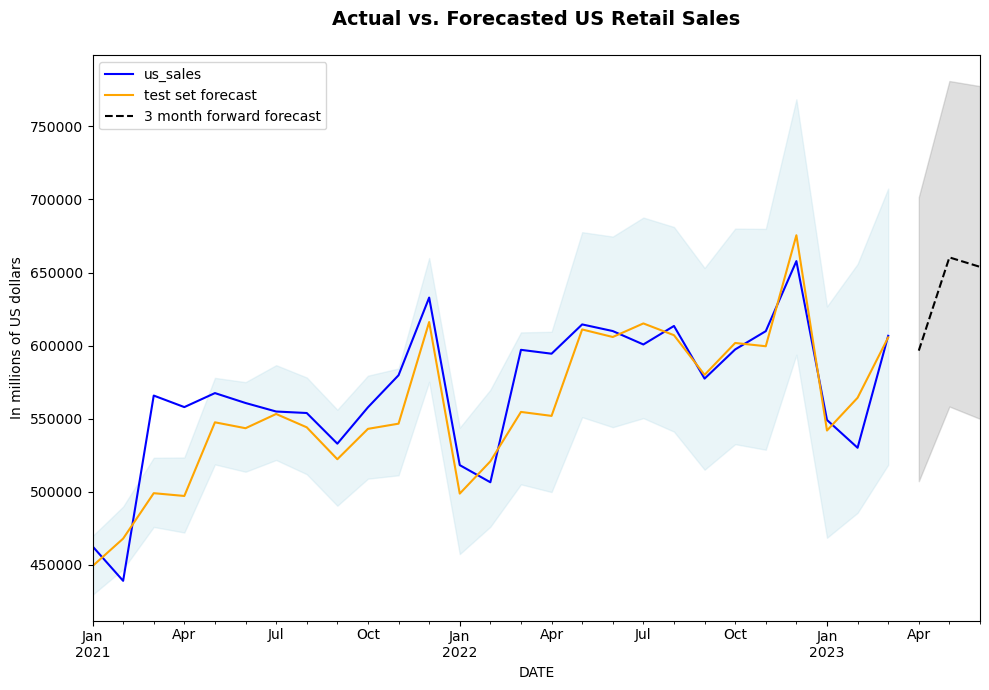

In [36]:
# Create an axis
fig, ax = plt.subplots(figsize=(10,7))

# Plot the train and test sets on the axis ax
us_test.plot(ax=ax, color='blue')
mean_forecast['2021-01':'2023-03'].plot(ax=ax, color='orange', label='test set forecast')
plt.fill_between(confidence_intervals['2021-01':'2023-03'].index, 
                 confidence_intervals['2021-01':'2023-03']['lower us_sales'], 
                 confidence_intervals['2021-01':'2023-03']['upper us_sales'], color='lightblue', alpha=0.25)

mean_forecast['2023-04':'2023-06'].plot(ax=ax, color='black', style='--', label='3 month forward forecast')
plt.fill_between(confidence_intervals['2023-04':'2023-06'].index, 
                 confidence_intervals['2023-04':'2023-06']['lower us_sales'], 
                 confidence_intervals['2023-04':'2023-06']['upper us_sales'], color='grey', alpha=0.25)

plt.title('Actual vs. Forecasted US Retail Sales\n', weight='bold', size=14)
plt.ylabel('In millions of US dollars')
plt.legend(loc='upper left')
plt.show()

In [37]:
pd.concat([us_test.loc['2023-01-01':'2023-06-01',:],
           round(mean_forecast['2023-01':'2023-06']), 
           round(confidence_intervals['2023-01':'2023-06']['lower us_sales']), 
           round(confidence_intervals['2023-01':'2023-06']['upper us_sales'])], axis=1)\
           .fillna('not released').tail(6)

,us_sales,predicted_mean,lower us_sales,upper us_sales
2023-01-01,549059.0,541841.0,468408.0,626786.0
2023-02-01,530024.0,564267.0,485482.0,655838.0
2023-03-01,606673.0,605577.0,518354.0,707477.0
2023-04-01,not released,596527.0,507122.0,701694.0
2023-05-01,not released,660356.0,558270.0,781109.0
2023-06-01,not released,653881.0,549828.0,777626.0


### V: Conclusion

We went through several steps to identify promising time series models.  A first step is to visualize the series to better understand trends and patterns.  If the raw data is not stationary (as is the case with US retail sales), it needs to be made stationary through various transformations.  First-order (y_t - y_t-1), log changes, etc. can be applied, and validated with adfuller and kpss stationarity tests' p-values.  Once the data is stationary, the AR and MA orders need to be identified through either visualizing the AC and PACF plots, or by identifying models with AR and MA orders corresponding to low AIC and BIC scores.  The AR and MA orders associated with the lowest AIC score was used for model fitting in this analysis.

We also incorporated two exogenous variables (unemployment rate and a recession indicator).  Exogenous factors can help explain model output but come at the cost of added complexity and possiblly over-fitting the model.  When we forecast out-of-sample (beyond the test set period), we not only have uncertainty in our estimates of the series but also on the exogenous data estimates.

Developing most machine learning model prototypes require fitting several models on training sets, and then evaluating their ouptus on unseen test data.  MAE and MAPE are two metrics that can be used to evaluate different time series models.  We were able to bring the MAPE down from a high of 14.61% (log difference model incorporating seasonality) to 3.44% (log difference model incorporating exogenous variables and seasonality).  
This model is forecasting 2023-04-01 US retail sales of $596527.0 million, a -1.6% decrease from actual 2023-03-01 sales.  The offical 2023-04-01 sales data will be released in mid-May.  It would be interesting to see how close the model's estimate comes to the actual data.